In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

stocks = pd.read_csv("stocks_cleaned.csv")
x, y = stocks.drop(["Name", "BSE Code", "NSE Code", "join_key", "t_1_price"], axis=1), stocks["t_1_price"]

encoder = LabelEncoder()
imputer = IterativeImputer(random_state=42)

x['Industry'] = encoder.fit_transform(x['Industry'])
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

In [41]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from matplotlib import pyplot as plt
import seaborn as sns

def score_dataset(x, y, model):
    x = x.copy()
    return cross_val_score(model, x, y).mean()

def make_mi_scores(x, y):
    x = x.copy()
    discrete = x.dtypes == int
    return pd.Series(mutual_info_regression(x, y, discrete_features=discrete, random_state=42), index=x.columns).sort_values(ascending=False)

def plot_scores(scores, n, high=True):
    plt.figure(figsize=(5, 5))
    plt.title('Mutual Information')
    if high:
        sns.barplot(x=scores[:n], y=scores.index[:n])
    else:
        sns.barplot(x=scores[(-1 * n):], y=scores.index[(-1 * n):])
    plt.ylabel('Features')
    plt.xlabel('Score')

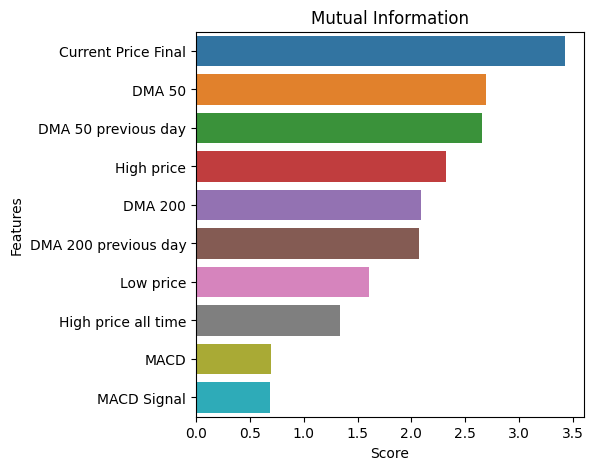

In [76]:
scores = make_mi_scores(x, y)
plot_scores(scores, 10)

In [50]:
features = scores[scores < 0.25].index
x_temp = x.drop(features, axis=1)
score_dataset(x_temp, y, Ridge(random_state=42))

0.9863696646682267

In [55]:
import optuna

def objective(trial):
    threshold = trial.suggest_float("threshold", 0, 0.9)

    features = scores[scores < threshold].index
    x_temp = x.drop(features, axis=1)
    
    return round(score_dataset(x_temp, y, Ridge(random_state=42)), 6)

study = optuna.create_study(direction="maximize")
study.enqueue_trial({"threshold": 0.25})
study.optimize(objective, n_trials=100)
study.best_trial

[I 2024-07-21 11:23:09,286] A new study created in memory with name: no-name-8ebcf469-00ff-48c9-832c-3f0206088ce0
[I 2024-07-21 11:23:09,383] Trial 0 finished with value: 0.98637 and parameters: {'threshold': 0.25}. Best is trial 0 with value: 0.98637.
[I 2024-07-21 11:23:09,405] Trial 1 finished with value: 0.988654 and parameters: {'threshold': 0.7900936959952585}. Best is trial 1 with value: 0.988654.
[I 2024-07-21 11:23:09,465] Trial 2 finished with value: 0.982777 and parameters: {'threshold': 0.48799519525243884}. Best is trial 1 with value: 0.988654.
[I 2024-07-21 11:23:09,501] Trial 3 finished with value: 0.982941 and parameters: {'threshold': 0.5089449962498137}. Best is trial 1 with value: 0.988654.
[I 2024-07-21 11:23:09,599] Trial 4 finished with value: 0.985741 and parameters: {'threshold': 0.2912954681076495}. Best is trial 1 with value: 0.988654.
[I 2024-07-21 11:23:09,801] Trial 5 finished with value: 0.985369 and parameters: {'threshold': 0.061135762069527914}. Best is

FrozenTrial(number=55, state=1, values=[0.99409], datetime_start=datetime.datetime(2024, 7, 21, 11, 23, 12, 535212), datetime_complete=datetime.datetime(2024, 7, 21, 11, 23, 12, 586737), params={'threshold': 0.6761755143145393}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'threshold': FloatDistribution(high=0.9, log=False, low=0.0, step=None)}, trial_id=55, value=None)

In [69]:
threshold = 0.6761755143145393

features = scores[scores < threshold].index
x = x.drop(features, axis=1)
score_dataset(x, y, Ridge(random_state=42))

0.9940896905773056

In [67]:
regressor = Ridge(random_state=42)
regressor.fit(x, y)
regressor.score(x, y)

weights = regressor.coef_
feature_importances = np.abs(weights)
feature_importances = feature_importances / feature_importances.sum()
importances = sorted([[name, importance] for name, importance in zip(x.columns, feature_importances)], key=lambda x: x[1], reverse=True)

for i in range(len(importances)):
    if weights[i] < 0:
        importances[i][1] *= -1
    print(importances[i][0] + ": " + str(importances[i][1]))

MACD Signal: -0.24749079020506665
DMA 200: -0.2033172440560217
DMA 200 previous day: 0.1955277793771166
MACD Signal Previous Day: -0.16980654011562576
MACD: 0.06554209316688767
DMA 50: 0.054484588127231094
DMA 50 previous day: -0.048140070464957524
Current Price Final: -0.011552411633995925
Low price: 0.0020845505019675384
High price: -0.001977112730099701
High price all time: 7.681962102975244e-05


In [70]:
x_new = x.copy()
x_new["Current Price Final"] = y

x['t_1_price_predicted'] = regressor.predict(x)
x["t_1_price_actual"] = y

x["error"] = x.apply(lambda row: max(row['t_1_price_predicted'] - row['t_1_price_actual'], 0), axis=1)
x["error"] = x["error"] * 100 / x["t_1_price_actual"]

x["t_2_price"] = regressor.predict(x_new)
x["growth"] = (x["t_2_price"] - x["Current Price Final"]) * 100 / x["Current Price Final"]

x["score"] = x["growth"] - x["error"]

In [102]:
df = pd.read_csv("prediction_1.csv")

In [103]:
df.head()

,High price,Low price,High price all time,DMA 50,DMA 200,DMA 50 previous day,DMA 200 previous day,MACD,MACD Signal,MACD Signal Previous Day,Current Price Final,t_1_price_predicted,t_1_price_actual,error,t_2_price,growth,score,join_key
0,234.94,90.00,234.94,182.05,157.72,180.47,157.09,12.82,9.09,8.16,225.65,235.229943,229.42,2.532449,240.188507,6.442946,3.910497,533022.0_20MICRONS
1,70.44,17.70,145.05,52.68,40.82,52.11,40.57,4.33,3.19,2.91,70.44,69.945617,72.33,0.000000,72.431475,2.827194,2.827194,526921.0_21STCENMGM
2,1065.00,442.10,1065.00,799.41,683.94,792.04,680.97,36.69,20.92,16.98,1009.40,1028.715911,1025.83,0.281325,1050.325777,4.054466,3.773141,542772.0_360ONE
3,1262.00,410.05,1262.00,943.41,787.12,936.17,783.76,77.58,81.34,82.28,1209.95,1389.276953,1329.94,4.461626,1547.096049,27.864461,23.402835,532067.0___NA__
4,63.90,30.25,164.50,37.97,41.20,38.03,41.25,-0.27,-0.34,-0.36,36.88,30.284107,32.75,0.000000,24.852047,-32.613755,-32.613755,532628.0_3IINFOLTD


In [111]:
shortlist = df[df.score > 30]

In [112]:
shortlist

,High price,Low price,High price all time,DMA 50,DMA 200,DMA 50 previous day,DMA 200 previous day,MACD,MACD Signal,MACD Signal Previous Day,Current Price Final,t_1_price_predicted,t_1_price_actual,error,t_2_price,growth,score,join_key
92,364.00,187.50,364.00,294.25,287.67,293.72,287.47,6.92,7.88,8.12,308.00,333.567431,373.06,0.0,419.138816,36.084031,36.084031,-1.0_LAWSIKHO
105,5000.00,1595.50,5000.00,3731.76,3221.52,3702.48,3209.18,268.77,208.86,193.89,4539.95,4911.730642,5324.89,0.0,5944.137687,30.929585,30.929585,540205.0___NA__
227,1510.00,239.40,1510.00,984.76,659.00,972.90,652.80,143.91,140.66,139.85,1291.00,1440.661083,1507.10,0.0,1724.890657,33.608881,33.608881,544037.0___NA__
622,3049.70,142.50,3049.70,1984.06,1099.72,1956.71,1084.10,268.85,267.49,267.15,2640.00,2879.008372,3220.27,0.0,3642.219364,37.962855,37.962855,543971.0___NA__
792,2427.90,277.55,2427.90,1748.67,1089.90,1729.63,1078.59,157.51,166.09,168.23,2267.25,2488.191931,2678.02,0.0,3028.464871,33.574369,33.574369,540678.0_COCHINSHIP
1142,298.60,142.00,298.60,211.42,234.40,208.44,233.89,18.42,8.60,6.15,298.60,324.772771,349.21,0.0,391.338522,31.057777,31.057777,-1.0_ESCONET
1267,517.00,191.40,517.00,397.70,350.83,394.17,349.49,26.84,19.21,17.31,488.05,519.512260,579.24,0.0,639.451617,31.021743,31.021743,505714.0_GABRIEL
1285,1072.00,361.80,1072.00,868.50,674.41,865.15,671.64,34.15,42.04,44.01,957.20,1028.317917,1122.99,0.0,1246.376322,30.210648,30.210648,526367.0_GANESHHOUC
1352,2760.00,1376.50,2760.00,2395.22,2026.21,2384.78,2019.93,84.50,95.74,98.55,2658.60,2878.398938,3098.52,0.0,3457.011962,30.031293,30.031293,500660.0_GLAXO
1930,727.85,169.35,727.85,564.81,406.12,559.73,403.27,42.44,47.43,48.68,696.85,779.483802,795.95,0.0,909.826935,30.562809,30.562809,533272.0_JWL


In [12]:
portfolio = pd.read_csv("shortlist.csv")
portfolio["units"] = ((portfolio["score"] * 1000000) / (portfolio["score"].sum() * portfolio["Current Price Final"])).round().astype(int)

In [14]:
portfolio["spent"] = portfolio["units"] * portfolio["Current Price Final"]
portfolio

,High price,Low price,High price all time,DMA 50,DMA 200,DMA 50 previous day,DMA 200 previous day,MACD,MACD Signal,MACD Signal Previous Day,Current Price Final,t_1_price_predicted,t_1_price_actual,error,t_2_price,growth,score,join_key,units,spent
0,364.00,187.50,364.00,294.25,287.67,293.72,287.47,6.92,7.88,8.12,308.00,333.567431,373.06,0.0,419.138816,36.084031,36.084031,-1.0_LAWSIKHO,197,60676.00
1,5000.00,1595.50,5000.00,3731.76,3221.52,3702.48,3209.18,268.77,208.86,193.89,4539.95,4911.730642,5324.89,0.0,5944.137687,30.929585,30.929585,540205.0___NA__,11,49939.45
2,1510.00,239.40,1510.00,984.76,659.00,972.90,652.80,143.91,140.66,139.85,1291.00,1440.661083,1507.10,0.0,1724.890657,33.608881,33.608881,544037.0___NA__,44,56804.00
3,3049.70,142.50,3049.70,1984.06,1099.72,1956.71,1084.10,268.85,267.49,267.15,2640.00,2879.008372,3220.27,0.0,3642.219364,37.962855,37.962855,543971.0___NA__,24,63360.00
4,2427.90,277.55,2427.90,1748.67,1089.90,1729.63,1078.59,157.51,166.09,168.23,2267.25,2488.191931,2678.02,0.0,3028.464871,33.574369,33.574369,540678.0_COCHINSHIP,25,56681.25
5,298.60,142.00,298.60,211.42,234.40,208.44,233.89,18.42,8.60,6.15,298.60,324.772771,349.21,0.0,391.338522,31.057777,31.057777,-1.0_ESCONET,175,52255.00
6,517.00,191.40,517.00,397.70,350.83,394.17,349.49,26.84,19.21,17.31,488.05,519.512260,579.24,0.0,639.451617,31.021743,31.021743,505714.0_GABRIEL,107,52221.35
7,1072.00,361.80,1072.00,868.50,674.41,865.15,671.64,34.15,42.04,44.01,957.20,1028.317917,1122.99,0.0,1246.376322,30.210648,30.210648,526367.0_GANESHHOUC,53,50731.60
8,2760.00,1376.50,2760.00,2395.22,2026.21,2384.78,2019.93,84.50,95.74,98.55,2658.60,2878.398938,3098.52,0.0,3457.011962,30.031293,30.031293,500660.0_GLAXO,19,50513.40
9,727.85,169.35,727.85,564.81,406.12,559.73,403.27,42.44,47.43,48.68,696.85,779.483802,795.95,0.0,909.826935,30.562809,30.562809,533272.0_JWL,74,51566.90


In [22]:
portfolio = pd.read_csv("portfolio.csv")

In [25]:
portfolio["spent"].sum()

996704.8

In [24]:
portfolio["growth"].sum()

595.4656153445361